<ipython-input-1-45ac1cb5b8ae>:57: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  J[:, i] = list(cal_deriv(params, input_data, i))


18039.746187992532
[[10.00939573]
 [ 0.79989939]]


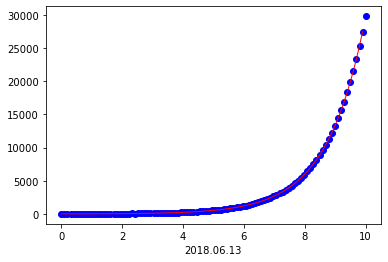

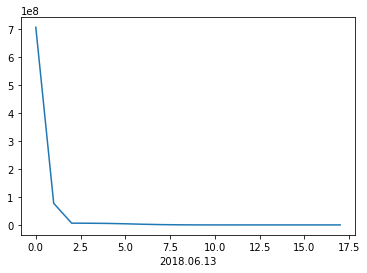

In [1]:
'''
#Implement LM algorithm only using basic python
#Author:Leo Ma
#For csmath2019 assignment4,ZheJiang University
#Date:2019.04.28
'''
import numpy as np
import matplotlib.pyplot as plt

# input data, whose shape is (num_data,1)
# data_input=np.array([[0.25, 0.5, 1, 1.5, 2, 3, 4, 6, 8]]).T
# data_output=np.array([[19.21, 18.15, 15.36, 14.10, 12.89, 9.32, 7.45, 5.24, 3.01]]).T


tao = 10 ** -3
threshold_stop = 10 ** -15
threshold_step = 10 ** -15
threshold_residual = 10 ** -15
residual_memory = []


# construct a user function
def my_Func(params, input_data):
    a = params[0, 0]
    b = params[1, 0]
    # c = params[2,0]
    # d = params[3,0]
    return a * np.exp(b * input_data)
    # return a*np.sin(b*input_data[:,0])+c*np.cos(d*input_data[:,1])


# generating the input_data and output_data,whose shape both is (num_data,1)
def generate_data(params, num_data):
    x = np.array(np.linspace(0, 10, num_data)).reshape(num_data, 1)  # 产生包含噪声的数据
    mid, sigma = 0, 5
    y = my_Func(params, x) + np.random.normal(mid, sigma, num_data).reshape(num_data, 1)
    return x, y


# calculating the derive of pointed parameter,whose shape is (num_data,1)
def cal_deriv(params, input_data, param_index):  # 求导
    params1 = params.copy()
    params2 = params.copy()
    params1[param_index, 0] += 0.000001
    params2[param_index, 0] -= 0.000001
    data_est_output1 = my_Func(params1, input_data)
    data_est_output2 = my_Func(params2, input_data)
    return (data_est_output1 - data_est_output2) / 0.000002


# calculating jacobian matrix,whose shape is (num_data,num_params)
def cal_Jacobian(params, input_data):
    num_params = np.shape(params)[0] #2
    num_data = np.shape(input_data)[0] #100
    J = np.zeros((num_data, num_params))
    for i in range(0, num_params):
        J[:, i] = list(cal_deriv(params, input_data, i))
    return J


# calculating residual, whose shape is (num_data,1)
def cal_residual(params, input_data, output_data):
    data_est_output = my_Func(params, input_data)
    residual = output_data - data_est_output
    return residual


'''
#calculating Hessian matrix, whose shape is (num_params,num_params)
def cal_Hessian_LM(Jacobian,u,num_params):
    H = Jacobian.T.dot(Jacobian) + u*np.eye(num_params)
    return H

#calculating g, whose shape is (num_params,1)
def cal_g(Jacobian,residual):
    g = Jacobian.T.dot(residual)
    return g

#calculating s,whose shape is (num_params,1)
def cal_step(Hessian_LM,g):
    s = Hessian_LM.I.dot(g)
    return s

'''


# get the init u, using equation u=tao*max(Aii)
def get_init_u(A, tao):
    m = np.shape(A)[0]
    Aii = []
    for i in range(0, m):
        Aii.append(A[i, i])
    u = tao * max(Aii)
    return u


# LM algorithm
def LM(num_iter, params, input_data, output_data):
    num_params = np.shape(params)[0]  # the number of params
    k = 0  # set the initt)
    # set the init par iter count is 0
    # calculating the init residual
    residual = cal_residual(params, input_data, output_data) # Y的差值
    # calculating the init Jocobian matrix
    Jacobian = cal_Jacobian(params, input_data) # 雅可比矩阵

    A = Jacobian.T.dot(Jacobian)  # calculating the init A 海森
    g = Jacobian.T.dot(residual)# calculating the init gradient g 梯度
    stop = (np.linalg.norm(g, ord=np.inf) <= threshold_stop)  # set the init stop
    u = get_init_u(A, tao)  # set the init u
    print(u)
    v = 2  # set the init v=2

    while ((not stop) and (k < num_iter)):
        k += 1
        while (1):
            Hessian_LM = A + u * np.eye(num_params)  # calculating Hessian matrix in LM
            step = np.linalg.inv(Hessian_LM).dot(g)  # calculating the update step
            if (np.linalg.norm(step) <= threshold_step):
                stop = True
            else:
                new_params = params + step  # update params using step
                new_residual = cal_residual(new_params, input_data, output_data)  # get new residual using new params
                rou = (np.linalg.norm(residual) ** 2 - np.linalg.norm(new_residual) ** 2) / (step.T.dot(u * step + g))
                if rou > 0:
                    params = new_params
                    residual = new_residual
                    residual_memory.append(np.linalg.norm(residual) ** 2)
                    # print (np.linalg.norm(new_residual)**2)
                    Jacobian = cal_Jacobian(params, input_data)  # recalculating Jacobian matrix with new params
                    A = Jacobian.T.dot(Jacobian)  # recalculating A
                    g = Jacobian.T.dot(residual)  # recalculating gradient g
                    stop = (np.linalg.norm(g, ord=np.inf) <= threshold_stop) or (
                                np.linalg.norm(residual) ** 2 <= threshold_residual)
                    u = u * max(1 / 3, 1 - (2 * rou - 1) ** 3)
                    v = 2
                else:
                    u = u * v
                    v = 2 * v
            if (rou > 0 or stop):
                break;

    return params


def main():
    # set the true params for generate_data() function
    params = np.zeros((2, 1))
    params[0, 0] = 10.0
    params[1, 0] = 0.8
    num_data = 100  # set the data number
    data_input, data_output = generate_data(params, num_data)  # generate data as requested
    # set the init params for LM algorithm
    params[0, 0] = 6.0
    params[1, 0] = 0.3

    # using LM algorithm estimate params
    num_iter = 100  # the number of iteration
    est_params = LM(num_iter, params, data_input, data_output)
    print(est_params)
    a_est = est_params[0, 0]
    b_est = est_params[1, 0]

    # 老子画个图看看状况
    plt.scatter(data_input, data_output, color='b')
    x = np.arange(0, 100) * 0.1  # 生成0-10的共100个数据，然后设置间距为0.1
    plt.plot(x, a_est * np.exp(b_est * x), 'r', lw=1.0)
    plt.xlabel("2018.06.13")
    plt.savefig("result_LM.png")
    plt.show()

    plt.plot(residual_memory)
    plt.xlabel("2018.06.13")
    plt.savefig("error-iter.png")
    plt.show()


if __name__ == '__main__':
    main()
